# Calculate the difference between two images

In EO, the difference between two images typically refers to computing the difference between two images of the same scene, captured at different times or under different conditions.

What “Difference Between Two Images” Means:

*Temporal Difference*:
- The most common usage is to compare images taken at different times of the same location. For example, in remote sensing, you might have satellite images of the same area captured on different dates. The “difference” here is a pixel-by-pixel subtraction between the images, which highlights changes that occurred over time. For example:
- For example: If the first image is captured on April 23, 2020, and the second on July 2, 2020, subtracting one from the other shows how the scene has changed between those two dates (e.g., changes in vegetation, water levels, urban development, etc.).

*Spectral Difference*:
- Sometimes, the difference might involve different spectral bands of the same image. For example, subtracting the Red band from the Near-Infrared (NIR) band in multispectral imagery to calculate a vegetation index like NDVI (Normalized Difference Vegetation Index).

*Why is temporal difference useful*?

This technique is very useful in remote sensing for identifying changes over time, such as deforestation, urban expansion, crop health, or flood damage. The difference image highlights areas where significant changes have occurred, while areas with little or no change will have pixel values close to zero.

In this notebooke we will focus on calculating temporal difference and visualizing it.


In [121]:
import openeo
from config import user,passwd,eo_service_url
import io
import numpy as np
from demo_regions import s2
from matplotlib import pyplot as plt
import rasterio
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [122]:
connection = openeo.connect(eo_service_url)
 
connection.authenticate_basic(username=user, password=passwd)

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

In [123]:
small_area = {
    "west": 13.15986156462585,
    "east": 13.208441734323664,
    "south": 55.57836893130869,
    "north": 55.60441458279001
}

In [124]:
def show_single_result_as_rgb(image_byte_like_object: bytes, title: str=""):

    # Open the image data using rasterio
    filelike = io.BytesIO(image_byte_like_object)
    im = rasterio.open(filelike)

    # 1. Read the bands as arrays
    r = im.read(1)  # Band 4 (Red)
    g = im.read(2)  # Band 3 (Green)
    b = im.read(3)  # Band 2 (Blue)

    r_normalized = normalize(r)
    g_normalized = normalize(g)
    b_normalized = normalize(b)

    # 3. Stack the bands into an RGB image
    rgb = np.dstack((r_normalized, g_normalized, b_normalized))

    # 4. Display the RGB image using matplotlib
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb)
    ax.set_title(title)
    plt.show()


# 2. Normalize the data to the range 0-255 for display
def normalize(array):
    array_min, array_max = np.percentile(array, (1, 99))  # Clip values between 1st and 99th percentile
    array = np.clip(array, array_min, array_max)  # Clip the extreme values
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)


In [125]:
res=connection.load_collection(collection_id=s2.s2_msi_l2a,
                         spatial_extent=small_area,
                         temporal_extent=["2024-06-02T00:00:00Z", "2024-08-28T10:00:00Z"],
                         bands=['b04', 'b03', 'b02'],
                        )



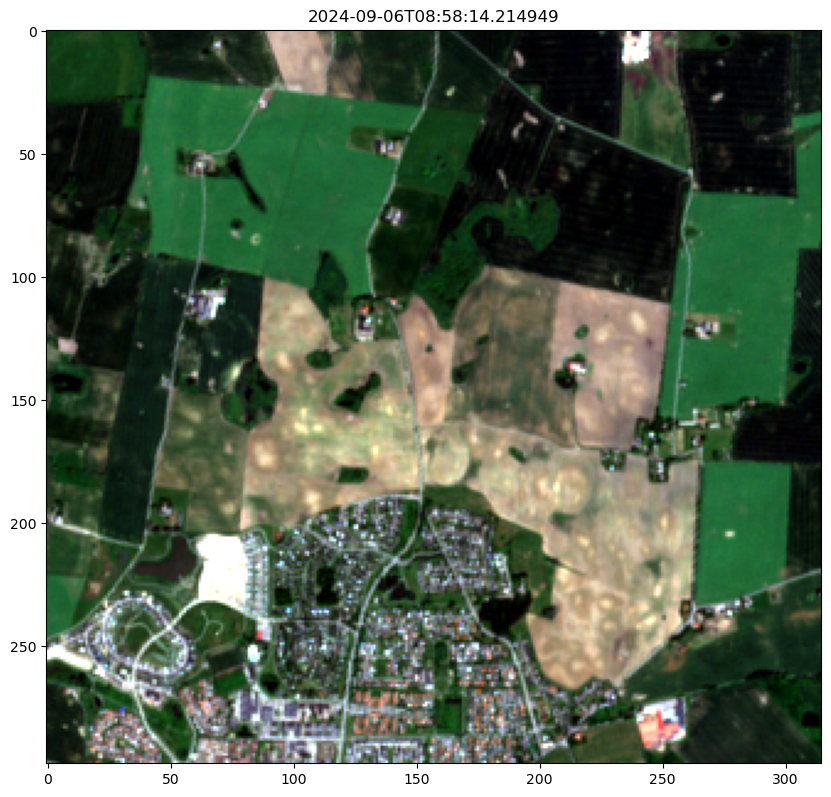

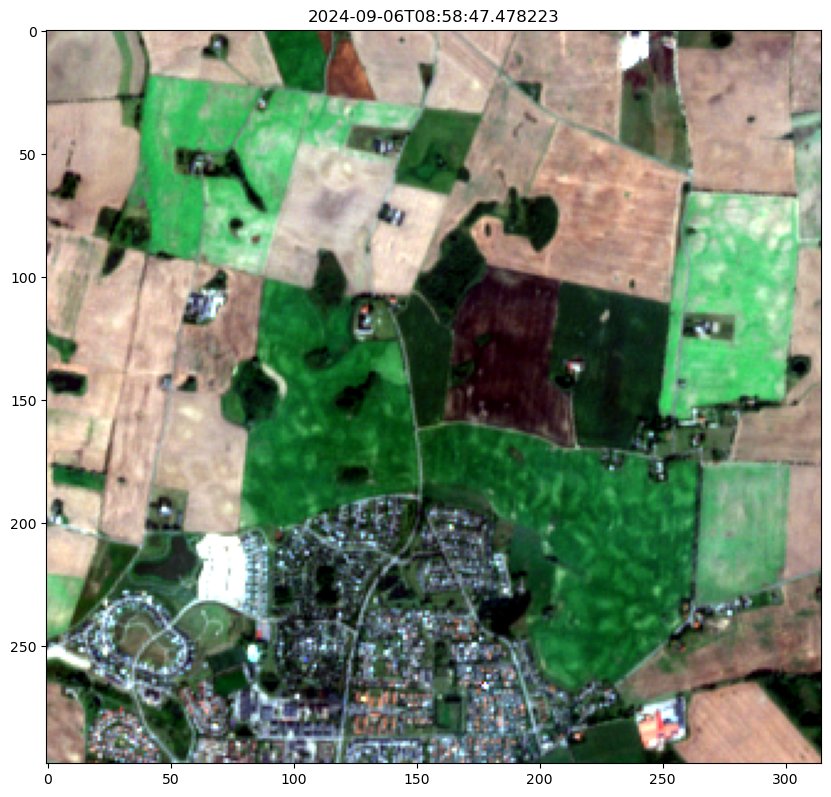

{'AREA_OR_POINT': 'Area', 'collection': 's2_msi_l2a', 'datetime_from_dim': '2024-09-06T08:58:14.214949', 'reduced_dimensions_min_values': '{"t": "2024-06-02T10:26:01.024000000"}'}
{'AREA_OR_POINT': 'Area', 'collection': 's2_msi_l2a', 'datetime_from_dim': '2024-09-06T08:58:47.478223', 'reduced_dimensions_min_values': '{"t": "2024-06-02T10:26:01.024000000"}'}


In [116]:
# `res` contains the loaded collection with two temporal extents
# Split the collection by temporal extents

first_image = res.reduce_dimension(dimension='t', reducer='first')
last_image = res.reduce_dimension(dimension='t', reducer='last')

show_single_result_as_rgb(first_image.download(format='gtiff'), "First image")

show_single_result_as_rgb(last_image.download(format='gtiff'), "Last image")



We can clearly see from the RGB image the difference in green in the two images. Therefore, in this example of calculating difference in image, we will pick out the green band.

In [126]:
# Select the green band (which is b03)
b03 = res.band("b03")

# Reduce the green band over time for first and last temporal points
b03_first_temporal = b03.reduce_dimension(dimension="t", reducer="first")
b03_last_temporal = b03.reduce_dimension(dimension="t", reducer="last")

# Calculate the temporal difference between the two images over the green band
difference_green_band = b03_first_temporal - b03_last_temporal

# Download the result for visualization
result_green_band = difference_green_band.download()

Now we will visualize the difference in the green band using "RdBu" colormap.

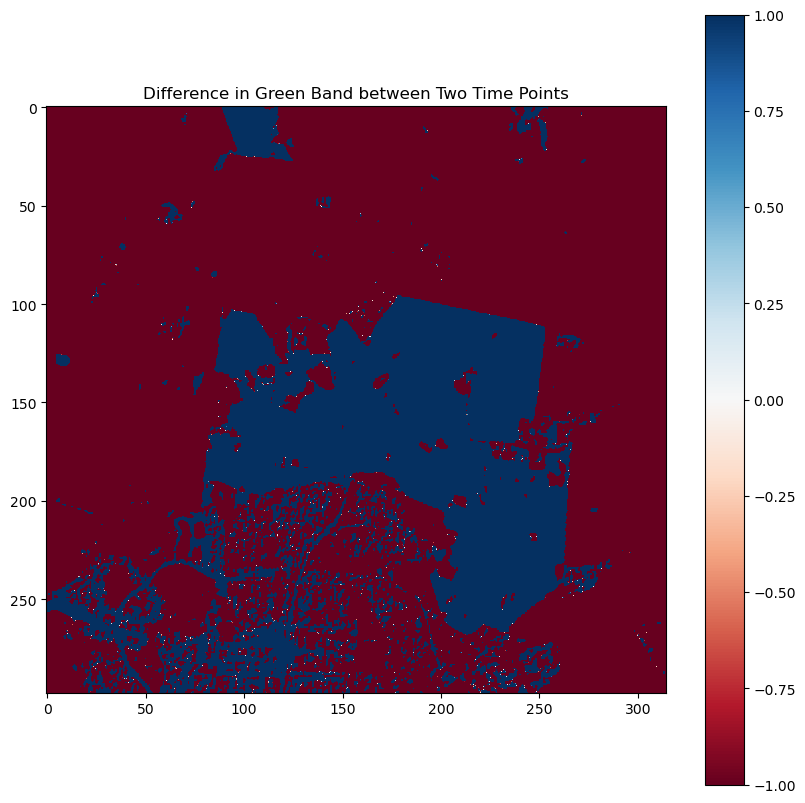

In [127]:

# Load the difference image into rasterio
filelike = io.BytesIO(result_green_band)
raster_data = rasterio.open(filelike)

# Read the data from the raster
image_data_green = raster_data.read(1)  # Read the first band (since it's single-band)

# Plot the difference image using imshow
fig, ax = plt.subplots(figsize=(10, 10))

# Adjust colormap to highlight differences in the green band
cax = ax.imshow(image_data_green, cmap='RdBu', vmin=-1, vmax=1)  # Adjust vmin and vmax based on data range

plt.title('Difference in Green Band between Two Time Points')

# Add the colorbar representing the values
plt.colorbar(cax, ax=ax)

# Show the plot
plt.show()

This difference plot shows the changes in reflectance values between two time points for the green band. Let’s break it down:

*Color Scheme (RdBu colormap)*:

- Red/Maroon Areas: These indicate negative values in the difference, meaning that the reflectance in the green band has decreased between the two time points.
- Blue Areas: These represent positive values in the difference, meaning that the reflectance in the green band has increased between the two time points.
- White Areas (around zero): These areas have little to no change in reflectance, indicating stability between the two time points.


*Spatial Patterns*:

- The large dark red regions are areas where the green reflectance has substantially decreased. This could be due to factors like vegetation loss, drying out.

- Areas in blue, where the reflectance has increased, might indicate vegetation growth, increased moisture, or any other factor that boosts green reflectance.